In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

In [2]:
# Load data/eng-fra.txt 

### Loading the data

- We will load the data from  `data/eng-fra.txt`. 

- We will represent each word in a language as a one-hot vector. Therefore we will need a unique index per word to use as the inputs and targets of the networks later.

The class `Lang` will contain two dictionaries: `word2index` and `index2word` as well as a count of each word `word2count` to use to later replace rare words.

In [3]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang  = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang  = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a lot of example sentences and we want to train something quickly, we’ll trim the data set to only relatively short and simple sentences. Here the maximum length is 10 words (that includes ending punctuation) and we’re filtering to sentences that translate to the form “I am” or “He is” etc. (accounting for apostrophes replaced earlier).

In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

- Read text file and split into lines, split lines into pairs
- Normalize text, filter by length and content
- Make word lists from sentences in pairs


In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925
['je suis satisfait de tout .', 'i m satisfied with everything .']


In [8]:
len(pairs)
print(pairs[0])
print(pairs[1])
print(pairs[2])
print(pairs[3])
print(pairs[4])
print(pairs[5])

['j ai ans .', 'i m .']
['je vais bien .', 'i m ok .']
['ca va .', 'i m ok .']
['je suis gras .', 'i m fat .']
['je suis gros .', 'i m fat .']
['je suis en forme .', 'i m fit .']


## Building the Seq to Seq model

A Sequence to Sequence network, or seq2seq network, or Encoder Decoder network, is a model consisting of two RNNs called the encoder and decoder.

- The encoder reads an input sequence and outputs a single vector, the context vector.
- The decoder reads the context vector to produce an output sequence.

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru.forward(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result
        
        
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.dropout_p = dropout_p                                ### Added by me

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)                 ### Added by me
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax()

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = self.dropout(output)                           ### Added by me

        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru.forward(output , hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result


#### Prepare training data


To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.



In [10]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    return result


def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)



#### Training the Model

To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the <SOS> token as its first input, and the last hidden state of the encoder as its first hidden state.

“Teacher forcing” is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input. Using teacher forcing causes it to converge faster but when the trained network is exploited, it may exhibit instability.

You can observe outputs of teacher-forced networks that read with coherent grammar but wander far from the correct translation - intuitively it has learned to represent the output grammar and can “pick up” the meaning once the teacher tells it the first few words, but it has not properly learned how to create the sentence from the translation in the first place.

Because of the freedom PyTorch’s autograd gives us, we can randomly choose to use teacher forcing or not with a simple if statement. Turn teacher_forcing_ratio up to use more of it.

In [11]:
print("SOS_token: ", SOS_token)
print("EOS_token:", EOS_token)

SOS_token:  0
EOS_token: 1


In [12]:
def train(input_variable,
          target_variable, 
          encoder,
          decoder,
          encoder_optimizer,
          decoder_optimizer,
          criterion,
          max_length=MAX_LENGTH):
    
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]
    
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_hidden = encoder_hidden
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
 
    # Without teacher forcing: use its own predictions as the next input
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder.forward(decoder_input, decoder_hidden)
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        decoder_input = Variable(torch.LongTensor([[ni]]))

        loss += criterion(decoder_output, target_variable[di])
        if ni == EOS_token:
            break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.data[0] / target_length

In [13]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

- Start a timer
- Initialize optimizers and criterion
- Create set of training pairs
- Start empty losses array for plotting


In [14]:
# nn.NLLLoss: The negative log likelihood loss. It is useful to train a classification problem with n classes.


In [15]:
teacher_forcing_ratio = 0.5


def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]
        
        loss = train(input_variable, 
                     target_variable,
                     encoder,
                     decoder, 
                     encoder_optimizer,
                     decoder_optimizer, 
                     criterion)
        

        print_loss_total += loss
        plot_loss_total += loss
        
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
           
    showPlot(plot_losses)

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [17]:
%matplotlib inline

In [18]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_hidden = encoder_hidden

    decoded_words = []

    for di in range(max_length):
        decoder_output, decoder_hidden = decoder.forward(decoder_input, decoder_hidden)
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))

    return decoded_words


In [19]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


1m 28s (- 5m 54s) (1000 20%) 4.5643
3m 3s (- 4m 35s) (2000 40%) 3.6476
4m 30s (- 3m 0s) (3000 60%) 3.4648
6m 2s (- 1m 30s) (4000 80%) 3.3881
7m 30s (- 0m 0s) (5000 100%) 3.2968


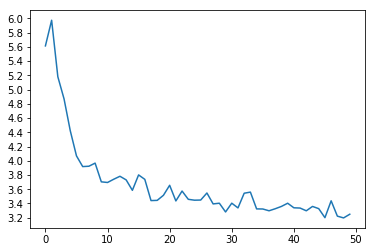

In [20]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words, 1)

trainIters(encoder1, decoder1, 5000, print_every=1000,learning_rate=0.001)

In [21]:
evaluateRandomly(encoder1, decoder1)

> elle est chanteuse .
= she is a singer .
< i re not . . <EOS>

> il est recherche par la police .
= he is hunted by the police .
< i re not . . <EOS>

> il a accepte de faire le travail .
= he s agreed to do the job .
< i re not . . <EOS>

> nous nous retirons .
= we re pulling back .
< i re not . . <EOS>

> elles sont sur le point de partir .
= they re about to leave .
< i re not . . <EOS>

> je suis dans la meme galere .
= i m in the same boat .
< i re not . . <EOS>

> il a une assuetude .
= he s addicted .
< i re not . . <EOS>

> ils restent .
= they re staying .
< i re not . . <EOS>

> je ne suis pas du genre jaloux .
= i m not the jealous type .
< i re not . . <EOS>

> c est un joueur invetere .
= he is a compulsive gambler .
< i re not . . <EOS>



1m 23s (- 5m 34s) (1000 20%) 3.3524
2m 44s (- 4m 6s) (2000 40%) 3.2337
4m 5s (- 2m 43s) (3000 60%) 3.2717
5m 23s (- 1m 20s) (4000 80%) 3.2818
6m 43s (- 0m 0s) (5000 100%) 3.2268


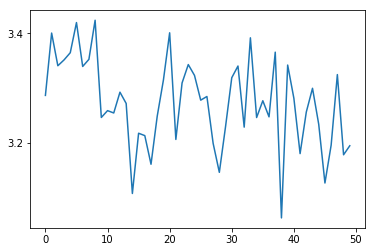

In [22]:
trainIters(encoder1, decoder1, 5000, print_every=1000,learning_rate=0.001)

In [23]:
evaluateRandomly(encoder1, decoder1)

> vous etes tous contre moi .
= you re all against me .
< i re not . . <EOS>

> j en ai marre de tous tes chichis .
= i m tired of all your fussing .
< i re not . . <EOS>

> nous nous portons mieux sans vous .
= we re better off without you .
< you re not . . <EOS>

> on peut te remplacer .
= you re replaceable .
< you re not . . <EOS>

> je travaille dans ma ferme .
= i m a farmer .
< i re not . . <EOS>

> je suis ici pour te sauver .
= i m here to save you .
< i re not . . <EOS>

> il a l esprit vif .
= he is sharp witted .
< i re not . . <EOS>

> j ai peur d y aller .
= i am afraid to go .
< i re not . . <EOS>

> je porte des lunettes de soleil .
= i m wearing sunglasses .
< i re not . . <EOS>

> c est un type etrange .
= he s a strange guy .
< you re not . . <EOS>



In [24]:
%matplotlib inline
output_words= evaluate(encoder1, decoder1, "je suis trop froid .")